In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fit import fit
from utils import latexify

In [12]:
df_small = pd.read_csv("data/traffic_small.csv", index_col=0, parse_dates=[0])

In [13]:
df_small.shape, df_small.index[0], df_small.index[-1]

((2000, 100),
 Timestamp('2019-10-09 06:00:00'),
 Timestamp('2019-12-31 13:00:00'))

In [115]:
def get_harmonics(x, period):
    return np.sin(2*np.pi * x / period), np.cos(2*np.pi * x / period)

In [116]:
A = []
# within a day
for hour in [24, 24/2, 24/3, 24/4, 24/5]:
    s, c = get_harmonics(np.array(df_small.index.hour), hour)
    A.append(s)
    A.append(c)
# within a week
for day in [24*7, 24*7/2, 24*7/3, 24*7/4, 24*7/5]:
    s, c = get_harmonics(np.array(df_small.index.dayofweek * 24 + df_small.index.hour) , day)
    A.append(s)
    A.append(c)
# within a year
# for month in [8760, 8760/2, 8760/3, 8760/4, 8760/5]:
#     s, c = get_harmonics(np.array((df_small.index.dayofyear - 1) * 24 + df_small.index.hour), month)
#     A.append(s)
#     A.append(c)

A.append(np.array(df_small.index.dayofweek <= 4).astype(float))

A = np.array(A).T
product_features = (A.reshape(A.shape[0], A.shape[1], 1) * A.reshape(A.shape[0], 1, A.shape[1])).reshape(A.shape[0], A.shape[1]**2)
A = np.hstack([A, product_features])

In [117]:
Xtrain = df_small.astype(float).values[:df_small.shape[0]//2]
Xtest = df_small.astype(float).values[df_small.shape[0]//2:]
Atrain = A[:A.shape[0]//2]
Atest = A[A.shape[0]//2:]
Xmean = Xtrain.mean(axis=0)
Amean = Atrain.mean(axis=0)
Xtrain -= Xmean
Xtest -= Xmean
Atrain -= Amean
Atest -= Amean
H = 6
M = 24

In [118]:
A.shape

(2000, 462)

In [119]:
_, _, _, Ptrain, Ftrain, _ = fit(Xtrain, M=M, H=H, alpha=.1, kappa=0, niter=1, rank=10, verbose=False, cuda=False)
_, _, _, Ptest, Ftest, _ = fit(Xtest, M=M, H=H, alpha=.1, kappa=0, niter=1, rank=10, verbose=False, cuda=False)

/home/shane/src/github.com/cvxgrp/low_rank_forecasting/code/fit.py:47: UserWarning: Cuda is available. To use it, set cuda=True.
  warnings.warn("Cuda is available. To use it, set cuda=True.")


In [120]:
np.mean(np.square(Ftrain)), np.mean(np.square(Ftest))

(1.107776321340356, 0.9620318992578554)

## Adjust for seasonality

In [121]:
theta = np.linalg.lstsq(Atrain, Xtrain, rcond=None)[0]

In [122]:
z, U, V, Ptrain, Ftrain, info = fit(Xtrain - Atrain @ theta, M=M, H=H, alpha=.1, kappa=0, niter=20, rank=20, verbose=True, cuda=False)

Setting lam to 0.864.
Setting up forecaster consistency.
0 | 28.997338900100736
1 | 25.093508188437486
2 | 23.54467678081427
3 | 23.0430954769105
4 | 22.89532428228383
5 | 22.85482926175344
6 | 22.838846421259433
7 | 22.830955322560367
8 | 22.827081647923364
9 | 22.823969208720623
10 | 22.821409804090536
11 | 22.819651905410876
12 | 22.818508029729088
13 | 22.817783925885188
14 | 22.81730762913806
15 | 22.816925237238802
16 | 22.816568846810238
17 | 22.816247137088745
18 | 22.81599375604359
19 | 22.815823437375613
Theta has rank 14
Time: 11.127280950546265


In [123]:
_, _, _, Ptest, Ftest, info = fit(Xtest - Atest @ theta, M=M, H=H, alpha=.025, kappa=0, niter=1, rank=10, verbose=True, cuda=False)

Setting lam to 0.735.
Setting up forecaster consistency.
0 | 54.9749202702519
Theta has rank 9
Time: 0.2581162452697754


In [124]:
np.mean(np.square(Ptrain @ U @ V - Ftrain)), np.mean(np.square(Ptest @ U @ V - Ftest))

(0.062058841759365053, 0.18387785773353327)

In [125]:
np.mean(np.square(Ptrain)), np.mean(np.square(Ftest))

(0.099467780409789, 0.20325546538063927)

In [126]:
_, _, _, Padjust, Fadjust, info = fit(Atest @ theta, M=M, H=H, alpha=.025, kappa=0, niter=1, rank=10, verbose=False, cuda=False)

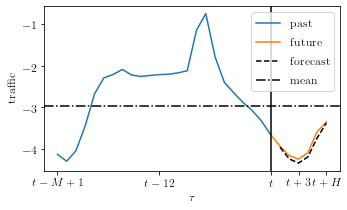

In [133]:
Fhat = Ptest @ U @ V

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

i = 50
j = 5
n = df_small.shape[1]

latexify(5)
plt.xticks([-M+1, -12, 0, 3, H], ["$t-M+1$", "$t-12$", "$t$", "$t+3$", "$t+H$"])
plt.plot(np.arange(-M+1,1), (Ptest + Padjust)[i][:M*n].reshape(M, n)[:,j] + Xmean[j], label='past')
plt.plot(np.arange(0,H+1), np.append((Ptest + Padjust)[i][:M*n].reshape(M, n)[:,j][-1], (Ftest + Fadjust)[i].reshape(H, n)[:,j]) + Xmean[j], label='future')
plt.plot(np.arange(1,H+1), (Fhat + Fadjust)[i].reshape(H, n)[:,j] + Xmean[j], '--', c='black', label='forecast')
plt.axvline(0, c='black')
plt.axhline(Xmean[j], linestyle='-.', c='black', label='mean')
plt.legend()
plt.ylabel("traffic")
plt.xlabel("$\\tau$")
plt.tight_layout()
plt.savefig("figs/traffic_forecast.pdf")

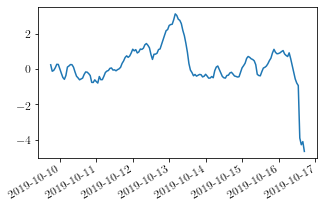

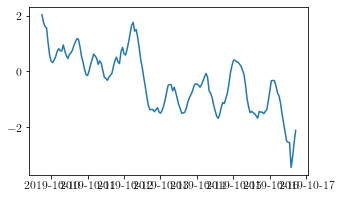

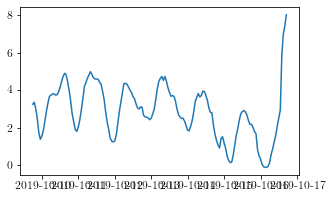

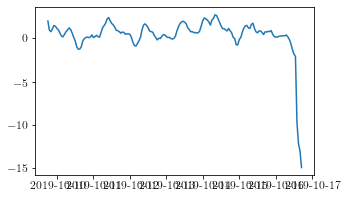

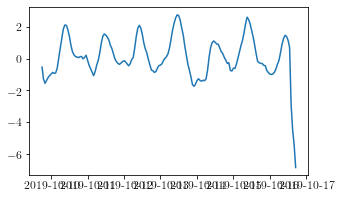

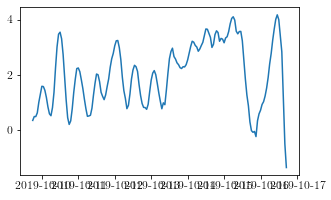

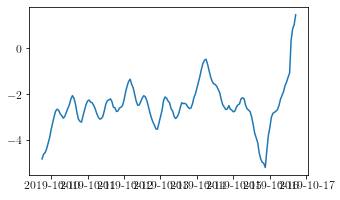

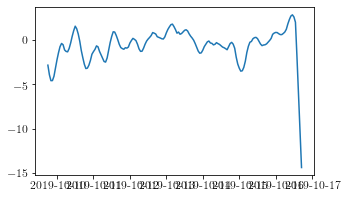

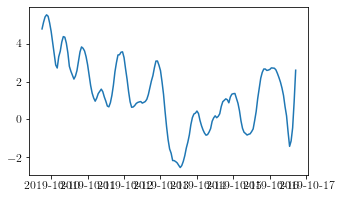

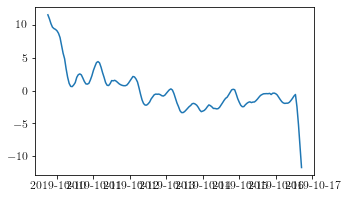

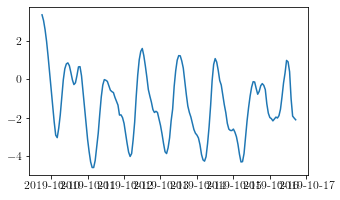

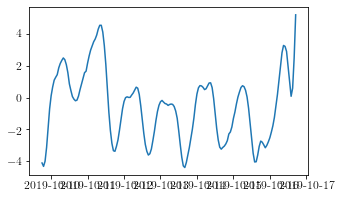

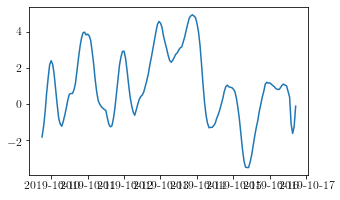

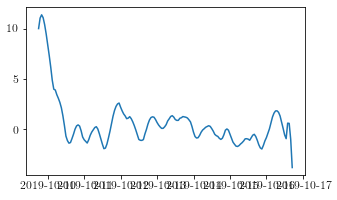

In [128]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
for i in range(z.shape[1]):
    plt.plot(df_small.index[12:12+24*7], z[:24*7,i])
    plt.show()

In [129]:
test_losses = []
alphas = np.logspace(-2,0,20)
ranks = []
for alpha in alphas:
    _, U, V, Ptrain, Ftrain, info = fit(Xtrain - Atrain @ theta, M=M, H=H, alpha=alpha, kappa=0, niter=20, rank=20, verbose=False, cuda=False)
    tl = np.mean(np.square(Ptest @ U @ V - Ftest))
    rank = U.shape[1]
    print (alpha, tl, rank)
    test_losses.append(tl)
    ranks.append(rank)

/home/shane/src/github.com/cvxgrp/low_rank_forecasting/code/fit.py:47: UserWarning: Cuda is available. To use it, set cuda=True.
  warnings.warn("Cuda is available. To use it, set cuda=True.")


0.01 0.23440309021779596 20
0.012742749857031334 0.2246176294905384 20
0.016237767391887217 0.2149722728937285 20
0.0206913808111479 0.20584532457532 20
0.026366508987303583 0.19774359655425952 20
0.03359818286283781 0.19100414943114913 20
0.04281332398719394 0.185995971234274 20
0.0545559478116852 0.18310888167029318 20
0.06951927961775606 0.18233925841909354 19
0.08858667904100823 0.1831010568270659 16
0.11288378916846889 0.1848234839441004 12
0.14384498882876628 0.18684029386478848 9
0.18329807108324356 0.18992523000770328 8
0.23357214690901212 0.19351210959822207 6
0.29763514416313175 0.19609141642427802 4
0.37926901907322497 0.1973149822523248 3
0.4832930238571752 0.1991316601877957 3
0.615848211066026 0.2002323495280075 2
0.7847599703514611 0.20172226319216024 2
1.0 0.20325546538063927 0


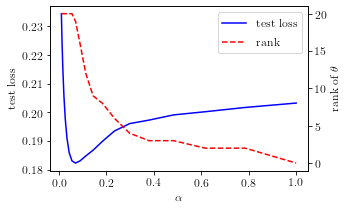

In [130]:
latexify(5)
fig, ax = plt.subplots()
l1 = ax.plot(alphas, test_losses, c='blue', label='test loss')
ax.set_ylabel("test loss")
ax2 = ax.twinx()
l2 = ax2.plot(alphas, ranks, '--', c='red', label='rank')
ax2.set_ylabel("rank of $\\theta$")
lns = l1 + l2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=1)
ax.set_xlabel("$\\alpha$")
plt.tight_layout()
plt.savefig("figs/traffic_test_loss.pdf")

In [131]:
U.shape[0] * V.shape[1]

1440000